# Ion Positions, Vibrational Modes, and Crosstalk Visualization

In [1]:
from tools.IonChainTools import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from math import sin, pi as π

## Ion Positions

The relative distances of the ions from each other in the trap only depends on the number ions. Using the function `calcPositions(N)` will give a vector representing the positions of `N` ions, with `0` being the center of the trap. These positions are given in units of the length scale for the trap. To convert these positions to meters, we must multiply the positions by a length scale that is determined by the specifications of the trap and the ion: the trap frequency, the mass of the ion, and the degree of ionization of the ion (its net charge). This length scale is calculated using `lengthScale(ν, M, Z)`. The units of `ν` are radians/sec and the units of `M` are kg.

In [3]:
calcPositions(5)

array([-1.74290321e+00, -8.22100756e-01, -1.19733315e-12,  8.22100756e-01,
        1.74290321e+00])

In [4]:
# The following lines are all equivalent
# Default mass is mass of Ca40
# Default ionization level is 1
lengthScale(2*π*1e6)
lengthScale(2*π*1e6, M=physconsts["mass_Ca40"])
lengthScale(2*π*1e6, Z=1)

4.4490477300769845e-06

In [5]:
calcPositions(5)*lengthScale(2*π*1e6)

array([-7.75425958e-06, -3.65756550e-06, -5.32699233e-18,  3.65756550e-06,
        7.75425958e-06])

We can see that the spacing between ions changes as the number of ions changes by plotting many chains simultaneously. The coloring in the below plot is such that corresponding ions are colored the same in each chain. For example, in chains with odd numbers of ions, the center ion is always the same color; and in chains with even numbers of ions the ion to the right of the center is always the same color. This allows you to see that when going from a chain of $N$ ions to a chain of $N+2$ ions, the $N$ original ions get pushed closer together symmetrically about the center.

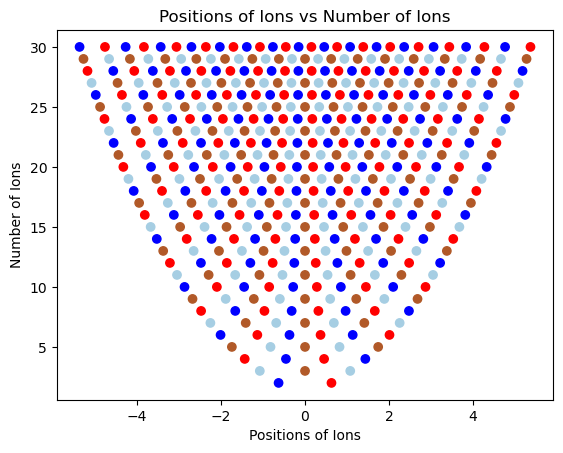

In [6]:
Nrange = range(2, 30+1)
fig, ax = plt.subplots()
for N in Nrange:
    positions = calcPositions(N)
    c = [(-1)**i for i in range(N)]
    if N%2 == 1:
        c = [(-1)**((N-1)/2-i) for i in range(N)]
        ax.scatter(positions, np.ones(N)*N, c=c, cmap='Paired')
    else:
        c = [(-1)**((N)/2-i) for i in range(N)]
        ax.scatter(positions, np.ones(N)*N, c=c, cmap='bwr')
ax.set_title('Positions of Ions vs Number of Ions')
ax.set_xlabel('Positions of Ions')
ax.set_ylabel('Number of Ions');

We observe that the spacing between the ions decreases as more ions are added to the string. We can visualize this by plotting the minimum spacing of the ions as a function of the number of ions.

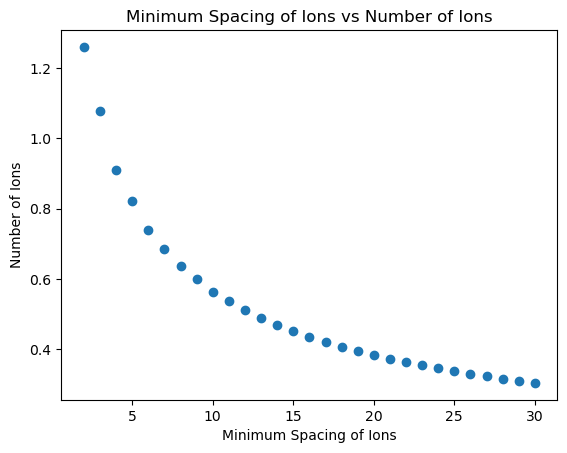

In [7]:
Nrange = range(2, 30+1)
fig, ax = plt.subplots()
minspacings = []
for N in Nrange:
    positions = calcPositions(N)
    minspacings.append(min([positions[i+1]-positions[i] for i in range(N) if i!=N-1]))
plt.scatter(Nrange, minspacings)
ax.set_title('Minimum Spacing of Ions vs Number of Ions')
ax.set_xlabel('Minimum Spacing of Ions')
ax.set_ylabel('Number of Ions');

## Crosstalk

We model crosstalk by considering one or more lasers, each centered on a particular ion in the chain. Each laser has a Gaussian beam intensity profile specified by a beamwidth.

The electric field strength at position $x$ due to a laser centered on position $x_c$ which a beamwidth $w$ is given by:

$$
E(x) = \exp\left(-\left(\frac{x-x_c}{w}\right)^2\right)
$$

If we define $E_L(x)$ to be the electric field strength at position $x$ from some laser $L$, then we can calculate the total intensity at position $x$ as:

$$
I(x) = \left[ \sum_L E_L(x) \right]^2
$$

Crosstalk can be calculated using the `calcCrosstalkIntensities(N, targets, beamwidth)` function, which returns a vector with the intensities at each ion position. The intensities are scaled so that an intensity of 1 corresponds to the intensity at the center of a single laser beam. `targets` is a vector of the indices of the target ions (which determine the centers of the beams), and `beamwidth` is the beamwidth of the lasers. `beamwidth` is in units of the length scale, which can be found using the `lengthScale` function.

In [8]:
calcCrosstalkIntensities(5, [1,3], 1)

array([0.18465251, 1.13844097, 1.03520042, 1.13844097, 0.18465251])

If you want to find the intensity at arbitrary positions, you can use the `calcCrosstalkIntensitiesAtPositions(beamcenters, bw, positions)` function. `beamcenters` is a vector of the positions of the centers of the beams, given in units of the length scale. `bw` is the beamwidth of the lasers, also in units of the length scale. `positions` are the positions to calculate the intensities at, in units of the length scale. We can use this to define a function to help us visualize the positions of the ions and the crosstalk at each position:

In [9]:
def plotPositionsAndCrosstalk(N, targets, bw):
    positions = calcPositions(N)
    beamcenters = [positions[t] for t in targets]
    intensities = calcCrosstalkIntensitiesAtPositions(beamcenters, bw, np.linspace(positions[0]-1, positions[-1]+1, 1000))
    gradient = intensities.reshape(1, -1)
    mappable = plt.imshow(gradient, extent=[positions[0]-1, positions[-1]+1, -1, 1], aspect=0.5, cmap='Reds')
    plt.scatter(positions, np.zeros(N))
    plt.colorbar(mappable, location='bottom', orientation='horizontal')
    plt.xlabel("Position (units of length scale)")
    plt.tick_params(left = False, labelleft = False)

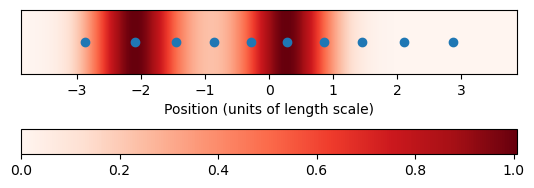

In [10]:
plotPositionsAndCrosstalk(10, [1,5], 1)

## Vibrational Modes

The axial and radial vibrational modes of an $N$-ion chain can be calculated using the `calcAxialModes(N, masses)` function and the `calcRadialModes(N, masses, νratio)` function respectively. `N` is the number of ions and `masses` is an optional parameter that is a list of the masses of each ion. `νratio`, which is only necessary for calculating radial modes, is the ratio of the radial trap frequency to the axial trap frequency (typically somewhere between 3 and 10). Only the ratios between the masses matter to the vibrational modes, so they can be provided in any units. Both functions return a list of vibrational modes in order of increasing mode frequency. Each vibrational mode is represented by a tuple where the first element of the tuple is the vibrational mode frequency and the second element is the mode vector. The vibrational mode frequencies are given in units of the axial trap frequency. Vibrational mode vectors represent ratios of displacements of the ions, so they do not depend on the length scale. The vibrational mode vectors are normalized.

In [11]:
calcAxialModes(2) # Default to equal masses for all ions

[(1.0, array([0.70710678, 0.70710678])),
 (1.7320508075688772, array([ 0.70710678, -0.70710678]))]

In [12]:
calcAxialModes(2, masses=[1,1]) # Equivalent to above

[(1.0, array([0.70710678, 0.70710678])),
 (1.7320508075688772, array([ 0.70710678, -0.70710678]))]

In [13]:
calcAxialModes(2, masses=[1,2]) # Unequal masses change vibrational modes

[(0.7962252170181257, array([0.59069049, 0.80689822])),
 (1.5381890013208515, array([ 0.9390708 , -0.34372377]))]

In [14]:
calcRadialModes(2, νratio=3)

[(2.8284271247461903, array([ 0.70710678, -0.70710678])),
 (3.0, array([0.70710678, 0.70710678]))]

To help visualize the modes, we can create an animation of them. The following function `animateAxialMode` produces an animation that is playable within the notebook. The ions are represented by blue circles, and the red dots indicate their equilibrium positions.

In [15]:
def animateAxialMode(N, m, masses=None, disp_size=1/3, freq = 2*π/25):
    '''Make an animation of an ion chain moving in a particular axial mode
    
    Params
        N : int
            number of ions in chain
        m : int
            index of vibrational mode (0 is lowest mode)
        masses : list (optional)
            masses of ions, in arbitrary units
        disp_size : float
            size of maximum displacement of ions from equilibrium position, in units of the length scale
        freq : float
            how fast to make the animation, in units of radians/frame
    '''
    fig, ax = plt.subplots()

    ax.set_xlim(( -5, 5))
    ax.set_ylim((-5, 5))
    ax.set_aspect('equal')

    if masses == None:
        masses = [1]*N
    eqpos = calcPositions(N)
    modevec = calcAxialModes(N, masses=masses)[m][1]

    ions = [plt.Circle((0, 0), 0.2*masses[i]**(1/2)) for i in range(N)]

    def init():
        for i, ion in enumerate(ions):
            ion.center = (eqpos[i], 0)
            ax.add_patch(ion)
        ax.scatter(eqpos, np.zeros(N), c="red", s=0.05)
        return ions

    def animate(t):
        for i, ion in enumerate(ions):
            ion.center = (eqpos[i]+sin(freq*t)*modevec[i]*disp_size, 0)
        return ions
    
    anim=animation.FuncAnimation(fig,animate,init_func=init,frames=round(2*π/freq), blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

In [16]:
animateAxialMode(5, 2)

If we look at the frequencies of the axial modes, we see that the frequency spectrum is hardly changed by the addition of more ions to the chain. The first $N-1$ modes of an $N$ ion chain are very similar in frequency to the $N-1$ modes of an $N-1$ ion chain, there is simply one more mode added on the end.

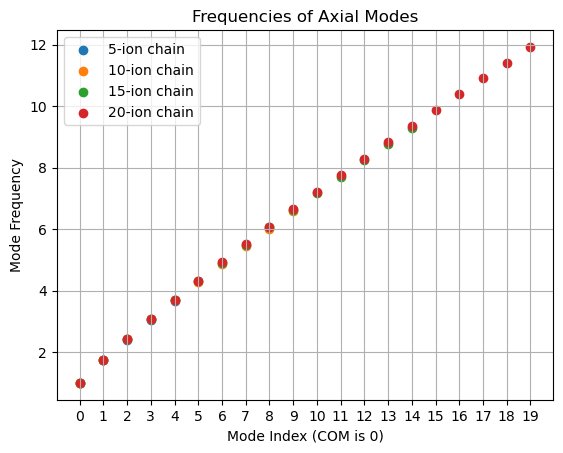

In [17]:
fig, ax = plt.subplots()
for N in (5, 10, 15, 20):
    freqs = [f for f, vec in calcAxialModes(N)]
    plt.scatter(range(N), freqs, label=f"{N}-ion chain")
ax.legend()
ax.set_title('Frequencies of Axial Modes')
ax.set_xlabel('Mode Index (COM is 0)')
ax.set_ylabel('Mode Frequency')
ax.set_xticks(np.arange(20));
ax.grid(visible=True)